In [1]:
import pandas as pd
import spark
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np


2024-10-27 02:32:24.871557: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 02:32:24.877782: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-27 02:32:24.950503: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-27 02:32:25.015913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1729989145.081376  112886 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1729989145.10

In [2]:
#read the data

activitats = pd.read_csv('data/activitats.csv')
notes = pd.read_csv('notes_arreglat.csv')
trameses = pd.read_csv('trameses_arreglat.csv')



In [3]:

# Filter activitats to keep only entries with an activitat_id present in trameses
activitats_filtered = activitats[activitats['activitat_id'].isin(trameses['activitat_id'].unique())]

# Save or display the filtered activitats DataFrame
activitats_filtered.to_csv('activitats_filtered.csv', index=False)


In [4]:
# Create a dictionary to map each unique activitat to a unique ID
activitat_unique_id = {activitats_filtered: idx for idx, activitats_filtered in enumerate(activitats_filtered['activitat'].unique(), start=1)}

# Map the activitat values to the unique IDs in the pastas column
activitats_filtered['shared_id'] = activitats_filtered['activitat'].map(activitat_unique_id)



/tmp/ipykernel_112886/311735768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activitats_filtered['shared_id'] = activitats_filtered['activitat'].map(activitat_unique_id)


In [5]:
# Define the aula_id values to filter
aula_ids = [87, 92, 143, 141]

activitats_filtered = activitats_filtered[activitats_filtered['aula_id'].isin(aula_ids)]

activitats_filtered.to_csv('activitats_with_shared.csv', index=False)
# Loop through each aula_id, filter, and save as a new CSV file
""" for aula_id in aula_ids:
    # Filter activitats for the current aula_id
    filtered_df = activitats_filtered[activitats_filtered['aula_id'] == aula_id]
    
    # Save the filtered DataFrame to a CSV file
    filtered_df.to_csv(f'activitats_aula_{aula_id}.csv', index=False) """


" for aula_id in aula_ids:\n    # Filter activitats for the current aula_id\n    filtered_df = activitats_filtered[activitats_filtered['aula_id'] == aula_id]\n    \n    # Save the filtered DataFrame to a CSV file\n    filtered_df.to_csv(f'activitats_aula_{aula_id}.csv', index=False) "

In [6]:
trameses_updated = trameses.merge(activitats_filtered[['activitat_id','aula_id']], on='activitat_id', how='left')
trameses_updated = trameses_updated[trameses_updated['aula_id'].notna()]
# Save the updated trameses dataset
trameses_updated.to_csv('updated_trameses.csv', index=False)


print("The aula_id has been added to the trameses dataset.")

The aula_id has been added to the trameses dataset.


In [7]:

# Step 1: Create a dictionary of unique activities per aula_id
unique_activities_per_aula = activitats_filtered.groupby('aula_id')['activitat_id'].unique().to_dict()

# Step 2: Get unique pairs of (userid, aula_id) from the existing data
unique_user_aula_pairs = trameses_updated[['userid', 'aula_id']].drop_duplicates()
unique_user_aula_pairs = unique_user_aula_pairs[unique_user_aula_pairs['aula_id'].notna()]

# Step 3: Initialize a list to store new entries
new_entries = []
id = 853717


# Step 4: Iterate over each (userid, aula_id) pair
for _, row in unique_user_aula_pairs.iterrows():
    userid = row['userid']
    aula_id = row['aula_id']

    
    # Get all activities associated with this aula_id
    required_activities = unique_activities_per_aula.get(aula_id, [])
    
    # Get activities that this user already has for the current aula_id
    existing_activities = trameses_updated[(trameses_updated['userid'] == userid) & (trameses_updated['aula_id'] == aula_id)]['activitat_id']
    
    # Find missing activities
    missing_activities = set(required_activities) - set(existing_activities)
    
    # Add a new entry for each missing activity
    for activitat_id in missing_activities:
        id +=1

        new_entry = {
            'id': id,  # Generate an id if needed
            'activitat_id': activitat_id,
            'userid': userid,
            'datesubmitted': 0,  # Fill with appropriate date if needed
            'grade': 0,
            'nevaluations': 0,
            'aula_id': aula_id,
            
        }
        new_entries.append(new_entry)

# Step 5: Create a DataFrame for the new entries and combine it with the existing entries
new_entries_df = pd.DataFrame(new_entries)
trameses_updated = pd.concat([trameses_updated, new_entries_df], ignore_index=True)
trameses_updated.to_csv('patatasbravas.csv', index=False)

# Step 6: Save the updated DataFrame to a new CSV


In [8]:
keywords = {
        "(OPCIONAL)": 6,

    "Problema": 1,
    "Entrega Practica": 2,
    "Entrega Pràctica": 2,
    "Lliurament Practica": 2,
    "Lliurament Pr�ctica": 2,
    "Lliurament Pràctica": 2,
    "Pr�ctica": 2,
    "RECUPERACI�": 3,
    "Recuperació": 3,
    "RECUPERACIÓ": 3,
    "Final FP": 4,
    "Exercici": 5,
    # Add more keywords and labels as needed
}

# Function to check for keywords in each activitat entry and assign a label
def label_activity(activitat):
    for keyword, label in keywords.items():
        if keyword in activitat:
            return label
    return 0  # Default label if no keywords match

# Apply the function to create a new 'label' column
activitats_filtered['label'] = activitats_filtered['activitat'].apply(label_activity)
activitats_filtered.to_csv('activitats_with_shared.csv', index=False)


In [9]:
# Load datasets
activitats = activitats_filtered
# rename the column 'grade' to 'max_grade'
activitats.rename(columns={'grade': 'max_grade'}, inplace=True)

trameses_updated = trameses_updated.merge(activitats[['activitat_id','shared_id','label','max_grade']], on='activitat_id', how='left')

trameses_updated.to_csv('fmunrunynyttfr.csv', index=False)


trameses_updated = trameses_updated[trameses_updated['aula_id'].notna()]
# Save the updated trameses dataset

trameses_updated.to_csv('fmunrunynyttfr.csv', index=False)

print("The aula_id has been added to the trameses dataset.")

The aula_id has been added to the trameses dataset.


In [10]:
trameses_updated = trameses_updated.sort_values(by=['shared_id', 'userid'])

In [11]:

# Initialize a dictionary to store data for each (userid, aula_id) pair
user_data = {}

# Iterate through each row in trameses
max_len = 0
for _, row in trameses_updated.iterrows():
    user_id = row['userid']
    aula_id = row['aula_id']
    grade = row['grade']
    max_grade = row['max_grade']
    shared_id = row['shared_id']
    nevaluations = row['nevaluations']
    label = row['label']
    datesubmitted = row['datesubmitted']
    
    # Use (userid, aula_id) tuple as a unique key in the dictionary
    key = (user_id, aula_id)
    
    # Initialize the list for this user-aula pair if not already created
    if key not in user_data:
        user_data[key] = []
    if(label == 1 or label == 6):
            user_data[key].append([grade/max_grade,shared_id, nevaluations,label]
            )
        
    
    # Append the grade, datesubmitted, and aula_id to the list for this user-aula pair
                          
    
    if len(user_data[key]) > max_len:
        max_len = len(user_data[key])

print(max_len)

153


In [12]:
# Flatten the user_data dictionary into an array
user_data_array = []
for key, values in user_data.items():
    user_data_array.append(np.array(values))
print(user_data_array[0])

user_data_array = np.array(user_data_array, dtype=object)


# Create a new array to store the F_Grade for each (userid, aula_id) combination
f_grade_array = []

# Iterate through the user_data_array and fetch the corresponding F_Grade from notes
for key, values in user_data.items():
    userid, aula_id = key[0], key[1]
    f_grade = notes.loc[(notes['userid'] == userid) & (notes['aula_id'] == aula_id), 'F_Grade']
    if not f_grade.empty:
        f_grade_array.append(f_grade.values[0])
    else:
        f_grade_array.append(np.nan)  # Append NaN if no F_Grade is found
    last = key
f_grade_array = np.array(f_grade_array)

print("User Data Array:")
print(user_data_array)
print("F_Grade Array:")
print(f_grade_array)



[[  1.     1.     1.     1.  ]
 [  1.     2.     4.     1.  ]
 [  1.     3.     1.     1.  ]
 [  1.     4.     3.     1.  ]
 [  1.     5.     3.     1.  ]
 [  1.     6.     2.     1.  ]
 [  1.     7.     2.     1.  ]
 [  0.     8.     0.     1.  ]
 [  1.    10.     1.     1.  ]
 [  1.    11.     1.     1.  ]
 [  1.    13.     1.     1.  ]
 [  1.    14.     4.     1.  ]
 [  1.    15.     1.     6.  ]
 [  1.    16.     1.     1.  ]
 [  1.    17.     1.     1.  ]
 [  1.    18.     1.     1.  ]
 [  1.    19.     1.     6.  ]
 [  1.    20.     1.     1.  ]
 [  1.    21.     1.     1.  ]
 [  1.    22.    17.     1.  ]
 [  1.    23.     1.     1.  ]
 [  0.97  24.     3.     1.  ]
 [  0.99  25.     4.     1.  ]
 [  1.    26.     1.     6.  ]
 [  1.    27.    14.     1.  ]
 [  1.    28.     1.     1.  ]
 [  0.96  29.     1.     1.  ]
 [  1.    30.     2.     1.  ]
 [  1.    31.     2.     6.  ]
 [  0.99  32.     2.     1.  ]
 [  0.    33.     0.     6.  ]
 [  0.96  34.     1.     1.  ]
 [  0.8 

In [13]:
print(len(user_data_array))

704


In [14]:
# Find the indices where f_grade_array is NaN
nan_indices = np.isnan(f_grade_array)
# Filter out the elements in user_data_array and f_grade_array where the indices match NaN
user_data_array_filtered = user_data_array[~nan_indices]
f_grade_array_filtered = f_grade_array[~nan_indices]
print(len(f_grade_array_filtered))
zero_indices = np.where(f_grade_array == 0)[0]
print(len(zero_indices))
# Remove all elements in the zero indices
user_data_array_filtered = np.delete(user_data_array_filtered, zero_indices, axis=0)
f_grade_array_filtered = np.delete(f_grade_array_filtered, zero_indices, axis=0)

print(len(f_grade_array_filtered))

701
40
661


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Normalization, Embedding
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Example array

# Split the array into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(user_data_array_filtered, f_grade_array_filtered, test_size=0.2, random_state=42)

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example jagged array (list of lists with varying lengths)

# Pad sequences to a fixed length (e.g., max length of 4)
padded_data = pad_sequences(X_train, padding='pre')

print("Padded Data:\n", padded_data)

# Convert to Tensor for model training
padded_data_tensor = tf.convert_to_tensor(padded_data, dtype=tf.float32)


# Hyperparameters
n_timesteps = max_len   # Number of timesteps (length of input sequence)
n_features = 5     # Number of features in each tuple (mark, date, id)
embedding_dim = 4  # Dimension for embedding the ID



# Define a "beefier" RNN model
model = Sequential([


    LSTM(512, return_sequences=True),
    Dropout(0.3),
    LSTM(258, return_sequences=True),
    Dropout(0.3),

    LSTM(128, return_sequences=True),
    Dropout(0.3),

    LSTM(128, return_sequences=True),
     Dropout(0.3),

    LSTM(32, return_sequences=False),
    Dropout(0.3),

    # Third LSTM layer


    Dense(64, activation='relu'),


    Dense(32, activation='relu'),



    Dense(1)  # Output layer for single prediction
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()


# Summary of the model
model.summary()

# Train the model
history = model.fit(padded_data, y_train, epochs=150, batch_size=17, validation_split=0.2)


Padded Data:
 [[[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  1 235   6   1]
  [  1 236   1   1]
  [  1 255   1   1]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  1 235   6   1]
  [  1 236   5   1]
  [  1 255   1   1]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  0 235   0   1]
  [  0 236   0   1]
  [  1 255   1   1]]

 ...

 [[  1   1   4   1]
  [  0   2   0   1]
  [  1   3   8   1]
  ...
  [  0 247   0   1]
  [  0 248   0   6]
  [  0 249   0   1]]

 [[  1   1   9   1]
  [  1   2   1   1]
  [  1   3   1   1]
  ...
  [  1 247   1   1]
  [  0 248   0   6]
  [  0 249   1   1]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  1 234   1   1]
  [  1 235   2   1]
  [  1 236   9   1]]]


2024-10-27 02:33:03.583862: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 19.8445 - mae: 3.7595 - val_loss: 8.1219 - val_mae: 2.3541
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 8.2309 - mae: 2.3634 - val_loss: 8.4512 - val_mae: 2.4883
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 7.8629 - mae: 2.3493 - val_loss: 8.1173 - val_mae: 2.4104
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 7.5955 - mae: 2.2967 - val_loss: 8.2091 - val_mae: 2.4352
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 7.9409 - mae: 2.3838 - val_loss: 8.3049 - val_mae: 2.4578
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 6.8201 - mae: 2.1614 - val_loss: 9.0529 - val_mae: 2.5901
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 7.9095 - mae: 2.4090 - val_loss: 8.9506 - val_mae: 2.5747
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 6.9763 - mae: 2.2222 - val_loss: 8.1325 - val_mae: 2.4148
Epoch 9/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 7.47

In [298]:
padded_data = pad_sequences(X_test, padding='post')

print("Padded Data:\n", padded_data)

# Convert to Tensor for model training
padded_data_tensor = tf.convert_to_tensor(padded_data, dtype=tf.float32)

predicted_final_mark = model.predict(padded_data_tensor)
print("Predicted Final Mark:", predicted_final_mark)


Padded Data:
 [[[  1   1   1   1]
  [  1   2   1   1]
  [  1   3   1   1]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  1   1   1   1]
  [  1   2   9   1]
  [  1   3   1   1]
  ...
  [  1 151   1   1]
  [  1 152   3   1]
  [  0   0   0   0]]

 [[  1   1   1   1]
  [  1   2   1   1]
  [  1   3   1   1]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 ...

 [[  1   1   1   1]
  [  1   2   1   1]
  [  1   3   1   1]
  ...
  [  1 151   1   1]
  [  1 152   1   1]
  [  0   0   0   0]]

 [[  1   1   2   1]
  [  1   2   2   1]
  [  1   3   1   1]
  ...
  [  0 247   0   1]
  [  0 248   0   6]
  [  1 249  13   1]]

 [[  1   1   1   1]
  [  1   2   1   1]
  [  1   3   1   1]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]]
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Predicted Final Mark: [[5.489415 ]
 [5.4894137]
 [5.489415 ]
 [5.489415 ]
 [5.489415 ]
 [5.489415 ]
 [5.489415 ]
 [5.4894137]
 [5.489415 ]
 [5.489415 ]
 [5.4894137]
 [5.4894

In [299]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming `predicted_final_mark` is the vector of your predictions
# and `y_test` is the ground truth vector

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predicted_final_mark)
print(f"Mean Absolute Error (MAE): {mae}")
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predicted_final_mark)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(max(y_test))

Mean Absolute Error (MAE): 2.229482859991547
Mean Squared Error (MSE): 7.1483510972493605
Root Mean Squared Error (RMSE): 2.673640046313146
9.9


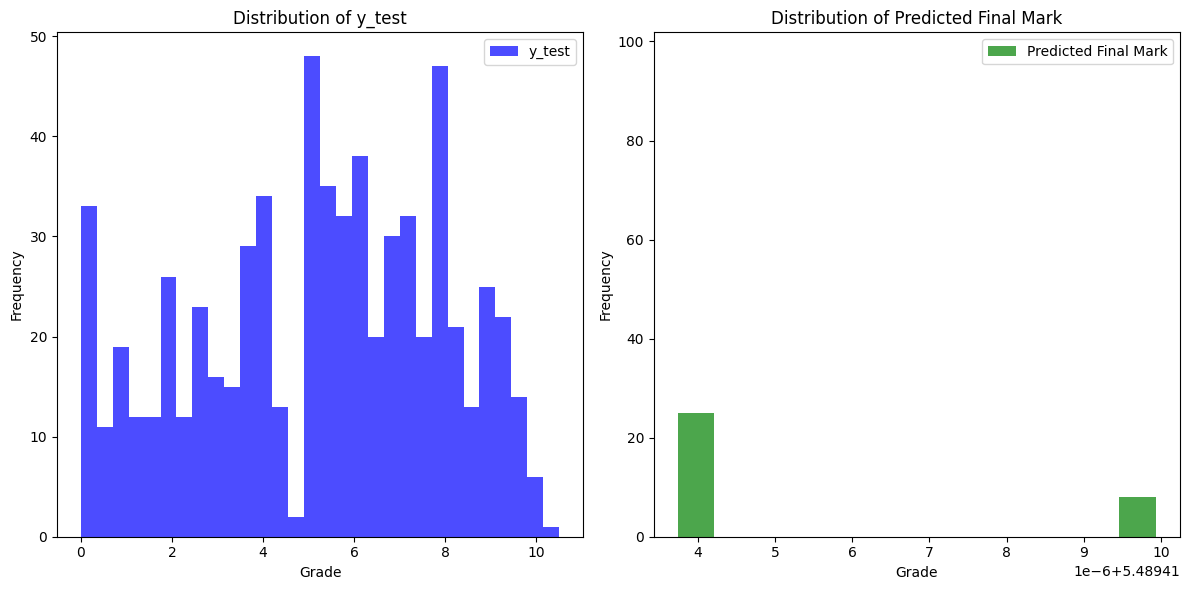

In [300]:
import matplotlib.pyplot as plt

# Plot the distribution of y_test
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(f_grade_array_filtered, bins=30, alpha=0.7, color='blue', label='y_test')
plt.title('Distribution of y_test')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.legend()

# Plot the distribution of predicted_final_mark
plt.subplot(1, 2, 2)
plt.hist(predicted_final_mark, bins=30, alpha=0.7, color='green', label='Predicted Final Mark')
plt.title('Distribution of Predicted Final Mark')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()